<a href="https://www.kaggle.com/code/janghoonhwang/cyclegan?scriptVersionId=192078285" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-9wgr2p47
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-9wgr2p47
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras_contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101060 sha256=e480a506923b4eb51cc1800b20135ca81d000174942e329ceef177ad526b9ddf
  Stored in directory: /tmp/pip-ephem-wheel-cache-c818dsng/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras_contrib


In [3]:
!pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [4]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.1.5
    Uninstalling typeguard-4.1.5:
      Successfully uninstalled typeguard-4.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires numpy<1.26,>=1.16.0, but you have numpy 1.26.4 which is incompatible.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os

import tensorflow_datasets as tfds

from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow_addons as tfa
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, LeakyReLU, Input, Activation, Concatenate, Conv2DTranspose
from tensorflow.keras.utils import plot_model, load_img
import PIL

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
np.random.seed(401)

2024-08-11 08:49:49.673005: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-11 08:49:49.673159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-11 08:49:49.849253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [6]:
# load the dataset path and take a look at all the folders inside 
IMG_DIR = '/kaggle/input/gan-getting-started'
# get a list of folder names of the working directory
print(os.listdir(IMG_DIR))

['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


In [7]:
Monet_jpg = os.path.join(IMG_DIR, f"monet_jpg")
Monet_tfrec = os.path.join(IMG_DIR, f"monet_tfrec")
Photo_jpg = os.path.join(IMG_DIR, f"photo_jpg")
Photo_tfrec = os.path.join(IMG_DIR, f"photo_tfrec")

In [8]:
print(f"There are {len(os.listdir(Monet_jpg))} image in Monet_jpg folder.")
print(f"There are {len(os.listdir(Monet_tfrec))} TFRecord files in Monet_tfrec folder.")
print(f"There are {len(os.listdir(Photo_jpg))} image in Photo_jpg folder.")
print(f"There are {len(os.listdir(Photo_tfrec))} TFRecord files in Photo_tfrec folder.")

There are 300 image in Monet_jpg folder.
There are 5 TFRecord files in Monet_tfrec folder.
There are 7038 image in Photo_jpg folder.
There are 20 TFRecord files in Photo_tfrec folder.


(256, 256, 3)

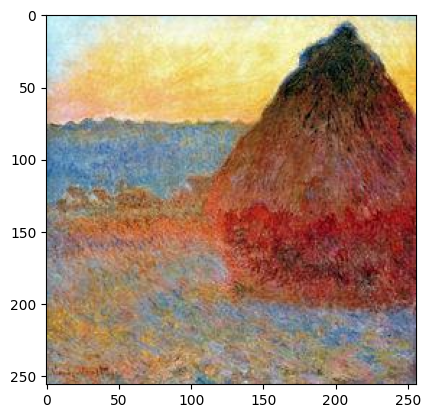

In [9]:
# sample painting
i = np.random.randint(0, 300)
sample = os.path.join(Monet_jpg, os.listdir(Monet_jpg)[i])
sample_pt = imread(sample)
plt.imshow(sample_pt)
sample_pt.shape

(256, 256, 3)

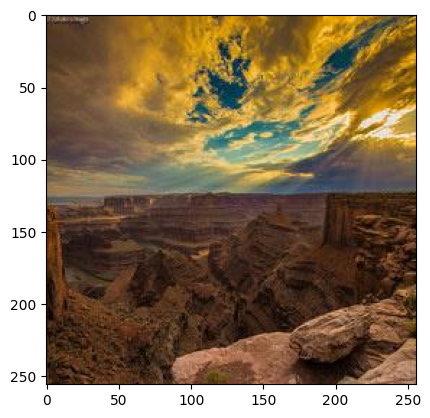

In [10]:
# sample photo
i = np.random.randint(0, 7038)
sample = os.path.join(Photo_jpg, os.listdir(Photo_jpg)[i])
sample_pt = imread(sample)
plt.imshow(sample_pt)
sample_pt.shape

In [11]:
# check dimsension of all the Monet_jpg images
Dim1 = []
Dim2 = []
CS = []
for ele in os.listdir(Monet_jpg):
    img = imread(os.path.join(Monet_jpg, ele))
    D1, D2, C = img.shape
    Dim1.append(D1)
    Dim2.append(D2)
    CS.append(C)
    
D_Monet = pd.DataFrame({'D1': Dim1, 'D2': Dim2, 'C':CS})
D_Monet.describe()

,D1,D2,C
count,300.0,300.0,300.0
mean,256.0,256.0,3.0
std,0.0,0.0,0.0
min,256.0,256.0,3.0
25%,256.0,256.0,3.0
50%,256.0,256.0,3.0
75%,256.0,256.0,3.0
max,256.0,256.0,3.0


In [12]:
# check dimension of all the Photo_jog images
Dim1 = []
Dim2 = []
CS = []
for ele in os.listdir(Photo_jpg):
    img = imread(os.path.join(Photo_jpg, ele))
    D1, D2, C = img.shape
    Dim1.append(D1)
    Dim2.append(D2)
    CS.append(C)
    
D_Photo = pd.DataFrame({'D1': Dim1, 'D2': Dim2, 'C':CS})
D_Photo.describe()

,D1,D2,C
count,7038.0,7038.0,7038.0
mean,256.0,256.0,3.0
std,0.0,0.0,0.0
min,256.0,256.0,3.0
25%,256.0,256.0,3.0
50%,256.0,256.0,3.0
75%,256.0,256.0,3.0
max,256.0,256.0,3.0


In [13]:
img_size = (256, 256)
img_channel = 3
img_shape = (256, 256, 3)

In [14]:
# fonction to load img and convert to array, scale
def load_images(path, size=(256, 256)):
    data_list = list()
    _list = os.listdir(path)
    for file in _list:
        img = load_img(os.path.join(path, file))
        img = img_to_array(img)
        img = img/127.5-1
        data_list.append(img)
    return np.asarray(data_list)

In [15]:
# load Monet painting, convert to array and save to local file
Monet_arr = load_images(Monet_jpg)
print(Monet_arr.shape)

(300, 256, 256, 3)


In [16]:
# load photo, convert to array and save to local file
Photo_arr = load_images(Photo_jpg)
print(Photo_arr.shape)

(7038, 256, 256, 3)


Discriminator

Define discriminator using PatchGAN which is designed based on the size of the receptive field that is the relationship between one output activation of the model to an area on the input image.
Let Ck denote a Convolution-BatchNorm-ReLU layer with k filteres, all convolutions are (4,4) spatial filters with stride 2 application. the 70x70 discriminator architecture is C64-C128-C256-C512. BatchNorm is not applied to the first C64 layer.

In [17]:
def CBR_block(d_in, k, instance_norm=True):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    d = Conv2D(k, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d_in)
    
    if instance_norm:
        d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    return d

In [18]:
def discriminator(img_shape): #(256, 256, 3):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    # image input
    in_img = Input(shape=img_shape)
    
    # C64
    d = CBR_block(in_img, 64, instance_norm=False)
    # C128
    d = CBR_block(d, 128, instance_norm=True)
    # C256
    d = CBR_block(d, 256, instance_norm=True)
    # C512
    d = CBR_block(d, 512, instance_norm=True)
    # layer before output
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    d = LeakyReLU(alpha=0.2)(d)
    # output layer
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    # define model
    model = Model(in_img, patch_out)
    # complie
    # mean squared error is used between the target values of class 1 (real) and class 0 (fake)
    # The loss for the discriminator is weighted by 50% for each model update to slow down the rate at which Discriminator learns relative to generator
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    
    return model

In [19]:
d_Monet = discriminator(img_shape)
d_photo = discriminator(img_shape)
d_Monet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       131200    
                                                                 
 instance_normalization (In  (None, 64, 64, 128)       256       
 stanceNormalization)                                            
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                             

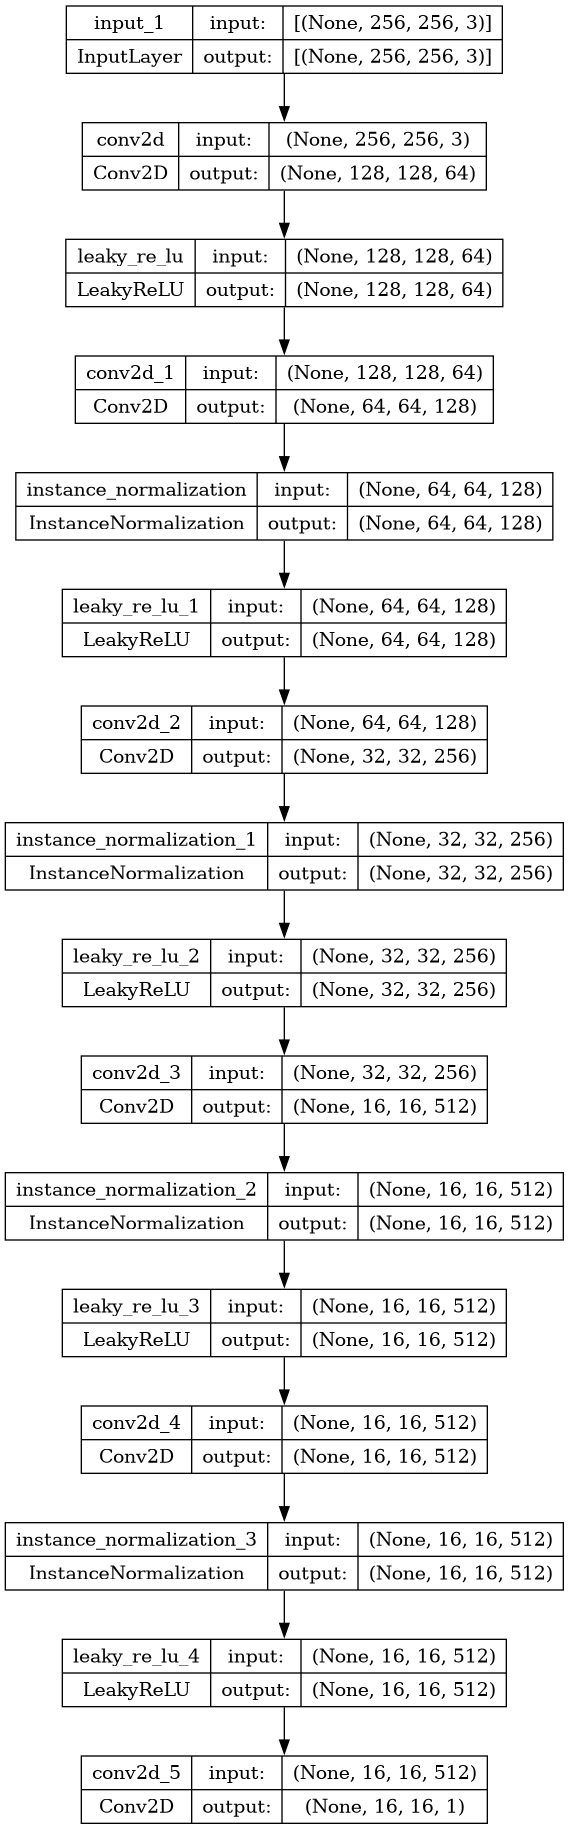

In [20]:
plot_model(d_Monet, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

**Generator

Define CycleGAN Generator which takes an input image and generates a translated image as output. The model use a combination of downsampling convolutional blocks, upsampling convolution blocks and resnet block in between.

In [21]:
def resnet_block(n_filters, input_layer):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    # convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    # convolutional layer
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)
    # concatenate channel-wise with input layer
    g = Concatenate()([g, input_layer])
    
    return g

In [22]:
def downsampling(input, k, size=(3,3), strides=(2,2)):
    #initialize weight
    init = RandomNormal(stddev=0.02)
    g = Conv2D(k, size, strides=strides, padding='same', kernel_initializer=init)(input)
    g = InstanceNormalization(axis=-1)(g)
    
    return g

In [23]:
def upsampling(input, k, size=(3,3), strides=(2,2)):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    g = Conv2DTranspose(k, size, strides=strides, padding='same', kernel_initializer=init)(input)
    g = InstanceNormalization(axis=-1)(g)
    g = Activation('relu')(g)
    
    return g

In [24]:
def generator(img_shape=(256, 256,3), n_resnet=9):
    # initialize weight
    init = RandomNormal(stddev=0.02)
    # image in
    in_img = Input(shape=img_shape)
    # C7S1-64
    g = downsampling(in_img, 64, size=(7,7), strides=(1,1))
    # D128
    g = downsampling(g, 128)
    # D256
    g = downsampling(g, 256)
    # R256
    for i in range(n_resnet):
        g = resnet_block(256, g)
    
    # U128
    g = upsampling(g, 128)
    # U64
    g = upsampling(g, 64)
    # C7S1-3
    g = Conv2DTranspose(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=1)(g)
    out_img = Activation('tanh')(g)
    
    # define model
    model = Model(in_img, out_img)
    
    return model

In [25]:
g_MtoPH = generator(img_shape)
g_PHtoM = generator(img_shape)
g_MtoPH.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_12 (Conv2D)          (None, 256, 256, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 instance_normalization_8 (  (None, 256, 256, 64)         128       ['conv2d_12[0][0]']           
 InstanceNormalization)                                                                           
                                                                                                  
 conv2d_13 (Conv2D)          (None, 128, 128, 128)        73856     ['instance_normalization

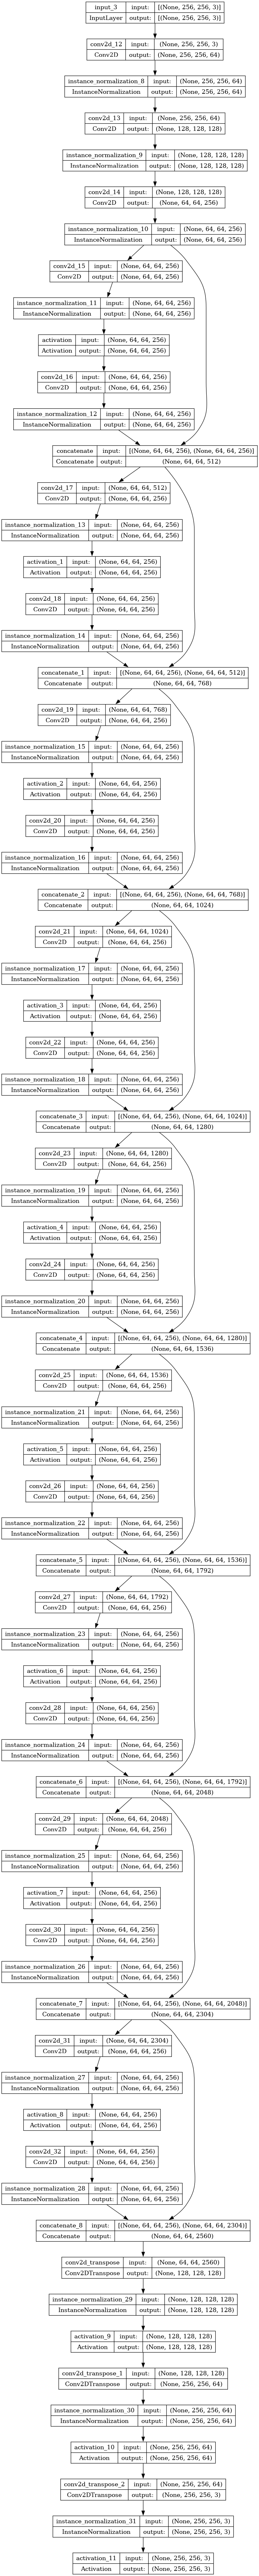

In [26]:
plot_model(g_MtoPH, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)